In [1]:
import pandas as pd
import numpy as np
import collections

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
import math
import random
import sklearn
import string

import nltk
from nltk.corpus import stopwords #Manually download
#nltk.download("stopwords")

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from util import rmse
from util import ndcg_k
from util import divSco_k
from util import gettail

from mf import MF

MIN_WORD_COUNT = 15
# #MODEL = "GaussianNB"
# MODEL = "MultinomialNB"

reallyfinalbooks = pd.read_csv('reallyfinalbooks.csv')
reallyfinalratings = pd.read_csv('reallyfinalratings.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

traintable = pd.pivot_table(data=train, index="newuser_id", columns="newbook_id", values="rating").sort_index(axis=0).sort_index(axis=1)
testtable = pd.pivot_table(data=test, index="newuser_id", columns="newbook_id", values="rating").sort_index(axis=0).sort_index(axis=1)

tail = gettail(reallyfinalratings)

In [2]:
reallyfinalbooks["genre_list"] = reallyfinalbooks["genre"].apply(lambda x: x.split("|")[:-1])

In [3]:
genre_count = {}
for genre_list in reallyfinalbooks["genre_list"]:
    for genre in genre_list:
        if genre not in genre_count:
            genre_count[genre] = 0
        genre_count[genre] += 1
genre_count_list = [(genre, genre_count[genre]) for genre in genre_count]
genre_count_list.sort(key=lambda x: x[1])

In [4]:
all_genre_list = genre_count_list[288:] #only use genres that had been taged on multiple books
all_genre_list.reverse()
all_genre_list

[('to-read', 7679),
 ('currently-reading', 5337),
 ('favorites', 4096),
 ('romance', 2713),
 ('fiction', 2671),
 ('young-adult', 2219),
 ('fantasy', 2036),
 ('ya', 1384),
 ('contemporary', 1200),
 ('mystery', 977),
 ('paranormal', 950),
 ('historical-fiction', 799),
 ('contemporary-romance', 623),
 ('series', 619),
 ('new-adult', 541),
 ('book-club', 487),
 ('non-fiction', 463),
 ('science-fiction', 408),
 ('books-i-own', 399),
 ('urban-fantasy', 381),
 ('nonfiction', 377),
 ('thriller', 360),
 ('sci-fi', 352),
 ('classics', 313),
 ('historical', 311),
 ('vampires', 306),
 ('graphic-novels', 304),
 ('graphic-novel', 287),
 ('paranormal-romance', 267),
 ('dystopian', 267),
 ('kindle', 257),
 ('horror', 257),
 ('humor', 246),
 ('childrens', 227),
 ('comics', 222),
 ('chick-lit', 213),
 ('dystopia', 207),
 ('owned', 202),
 ('crime', 196),
 ('memoir', 193),
 ('erotica', 190),
 ('historical-romance', 142),
 ('middle-grade', 140),
 ('picture-books', 128),
 ('history', 117),
 ('sports', 112),

In [5]:
for genre, _ in all_genre_list:
    reallyfinalbooks[genre] = reallyfinalbooks["genre_list"].apply(lambda l: 1 if genre in l else 0)

In [6]:
reallyfinalbooks[[genre for genre, _ in all_genre_list]]

,to-read,currently-reading,favorites,romance,fiction,young-adult,fantasy,ya,contemporary,mystery,...,harry-bosch,theatre,theology,dance,baseball,on-writing,physics,photography,erotic,read-2015
0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,1,1,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,1,0,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
D = reallyfinalbooks[[genre for genre, _ in all_genre_list]].values
m = D.shape[0]
X = (D - np.mean(D, axis=0)) / np.sqrt(m)
u, s, vt = np.linalg.svd(X, full_matrices=False)

In [19]:
t = u @ np.diag(s)
print(t.shape)

(8000, 379)


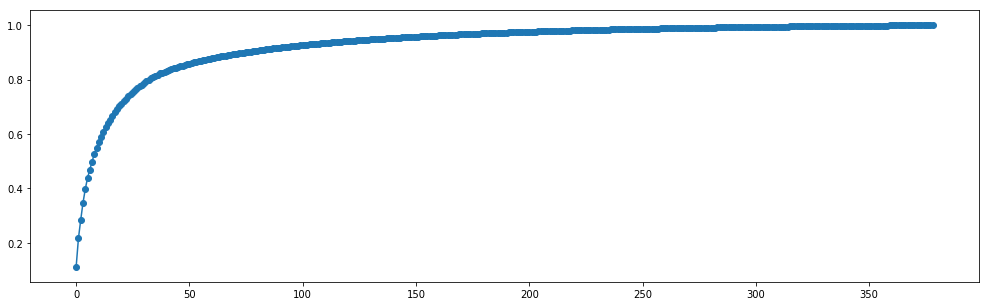

In [21]:
plt.figure(figsize=(17,5))
plt.plot(np.arange(len(s)), np.cumsum(s**2 / sum(s** 2)));
plt.scatter(np.arange(len(s)), np.cumsum(s**2 / sum(s** 2)));

In [22]:
np.cumsum(s**2 / sum(s** 2))

array([ 0.11285291,  0.21640028,  0.28382925,  0.34646042,  0.3964459 ,
        0.43828144,  0.46860979,  0.49882136,  0.52575916,  0.55001038,
        0.57166385,  0.58988044,  0.60768582,  0.62422386,  0.63972038,
        0.65346193,  0.66647348,  0.67926936,  0.69083977,  0.70133343,
        0.71116955,  0.72072138,  0.72995992,  0.73828044,  0.74617713,
        0.75399462,  0.76169863,  0.76898069,  0.77584652,  0.78214014,
        0.78841829,  0.79426039,  0.79974921,  0.80488172,  0.80993695,
        0.81455268,  0.81886428,  0.82270926,  0.82616474,  0.82929165,
        0.83233718,  0.83535645,  0.83835362,  0.84126274,  0.84402567,
        0.84668875,  0.84926109,  0.85175167,  0.85416593,  0.85651892,
        0.85876866,  0.86098696,  0.86314335,  0.86529183,  0.86739214,
        0.8694636 ,  0.87147625,  0.87347632,  0.87541373,  0.87721893,
        0.87896716,  0.88065586,  0.88232924,  0.88395983,  0.88553471,
        0.88709471,  0.88860342,  0.89004649,  0.89145396,  0.89

In [25]:
print(t[:,:20].shape)
np.cumsum(s**2 / sum(s** 2))[:20]

(8000, 20)


array([ 0.11285291,  0.21640028,  0.28382925,  0.34646042,  0.3964459 ,
        0.43828144,  0.46860979,  0.49882136,  0.52575916,  0.55001038,
        0.57166385,  0.58988044,  0.60768582,  0.62422386,  0.63972038,
        0.65346193,  0.66647348,  0.67926936,  0.69083977,  0.70133343])